In [10]:
#imports
%reload_ext autoreload
%autoreload 2
%matplotlib inline 

from matplotlib import pyplot as plt

from utils.basic_utils import *
from utils.fundamental import chain_outlier, get_focus_tickers, best_performers
from utils.pricing import load_px_close, get_return_intervals 
from utils.pricing import dummy_col, discret_rets, sample_wgts, px_fwd_ret
from utils.pricing import px_mom_feats, px_mom_co_feats_light, px_fwd_rets, get_ind_index
from utils.pricing import eq_wgt_indices, to_index_form, rename_col

pd.options.display.float_format = '{:,.2f}'.format

import time, os, sys
from tqdm import tqdm

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, log_loss, precision_recall_fscore_support
from sklearn.metrics import precision_score, roc_auc_score

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

import numpy as np
import keras
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD, Adam, Adagrad, Adadelta, Adamax, Nadam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.callbacks import CSVLogger
from keras.layers import BatchNormalization

In [11]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

### Context data

In [ ]:
# get latest pricing file from inferece server
px_close_ds = context['px_close']
tmp_path = context['tmp_path']
os.makedirs(tmp_path, exist_ok=True)
!scp -i ~/.ssh/qc_infra.pem ubuntu@52.13.205.29:~/inception/tmp/{px_close_ds} {tmp_path}{px_close_ds}

In [12]:
# context
bench = '^GSPC'
y_col = 'fwdReturn'
tickers = excl(config['companies'], [])

context = {
    'ml_path': '../ML/',
    'model_name': 'micro_TF.h5',
    'tmp_path': '../tmp/',
    'ds_name': 'co-technicals-ds',
    'px_close': 'universe-px-ds',
    'trained_cols': 'micro_TF_train_cols.npy',
    'look_ahead': 120,
    'look_back': 252*5,
    'load_ds': True,
    'scale': True,
    'test_size': .05,
    'verbose': True,
    's3_path': 'recommend/micro_ML/',
    'units': 850,
    'max_iter': 50,
    'l2_reg': 0.01,
}

In [13]:
# Quotes, profile, and industries
dates = read_dates('quote')
tgt_date = dates[-1] # last date saved in S3
print(f'Target date: {tgt_date}')

equity_symbols = config['companies']

quotes = load_csvs('quote_consol', [tgt_date])
quotes = quotes.loc[quotes.symbol.isin(equity_symbols)]
quotes.set_index('symbol', drop=False, inplace=True)

profile = load_csvs('summary_detail', ['assetProfile'])
profile = profile.loc[profile.symbol.isin(equity_symbols)]
profile.set_index('symbol', drop=False, inplace=True)

Target date: 2019-05-17
Loading file quote/csv/2019-05-17
Loading file summary-categories/assetProfile


In [14]:
# load stored pricing
px_close = load_px_close(
    context['tmp_path'], context['px_close'], context['load_ds']).drop_duplicates()
print('px_close.info()', px_close.info())

fwd_ret_labels = ["bear", "short", "neutral", "long", "bull"]
clean_co_px = px_close.dropna(subset=[bench])[tickers].fillna(method='ffill')

cut_range = get_return_intervals(
    clean_co_px, 
    context['look_ahead'], 
    tresholds=[0.25, 0.75])

print(f'Return intervals {np.round(cut_range, 3)}')

<class 'pandas.core.frame.DataFrame'>
Index: 4674 entries, 2004-05-16 to 2019-05-17
Columns: 1291 entries, 0700.HK to KRW=X
dtypes: float32(1291)
memory usage: 23.1+ MB
px_close.info() None
Return intervals [  -inf -0.176 -0.107  0.14   0.252    inf]


In [15]:
# Training/inference subset
tgt_sectors = [
    'Technology',
    'Healthcare',
    'Industrials',
    'Basic Materials',
    'Consumer Cyclical',
    'Financial Services',
    'Consumer Defensive',
    'Real Estate',
    'Utilities',
    'Communication Services',
    'Energy',
]

# tickers = list(profile.loc[profile.sector.isin(tgt_sectors), 'symbol'])
tickers = list(best_performers(clean_co_px, tickers=tickers, years=10, quantile=0.75).index)

context['tickers'] = tickers
print(f'{len(tickers)} companies')

248 companies


### Final

In [16]:
def pre_process_ds(context):
    
    tickers = context['tickers']
    sectors = profile.loc[profile.symbol.isin(tickers)].sector.unique()
    industries = profile.loc[profile.symbol.isin(tickers)].industry.unique()
    print(f'Sectors: {sectors.shape[0]}, Industries: {industries.shape[0]}')
    
    indices_df = pd.concat(
        [eq_wgt_indices(profile, px_close, 'sector', sectors, subset=tickers),
        eq_wgt_indices(profile, px_close, 'industry', industries, subset=tickers),
        to_index_form(px_close[bench], bench)], 
        axis=1).drop_duplicates()
    
    # create price momentum features
    tmp_path = context['tmp_path']
    ds_name = context['ds_name']

    super_list = []
    for i, ticker in tqdm(enumerate(tickers)):
        try:
            close = px_close[ticker].dropna()
            ft_df = px_mom_feats(close, ticker, incl_name=False)
            if ticker in profile.symbol.unique():
                top_groups = tuple([bench, profile.loc[ticker, 'sector']])
                co = px_mom_co_feats_light(close, indices_df, top_groups)
                ft_df = pd.concat([ft_df, co.loc[ft_df.index, :]], axis=1)
                super_list.append(ft_df.copy())
            else: print(ticker, 'missing profile, skipping')
        except Exception as e: 
            print("Exception: {0} {1}".format(ticker, e))

    joined_df = pd.concat(super_list, axis=0)
    joined_df = chain_outlier(joined_df, None)
        
    # basic impute and scaling
    scale_on = context['scale']
    scaler = StandardScaler()
    num_cols = numeric_cols(joined_df)
#     joined_df.loc[:, num_cols] = joined_df[num_cols].replace([np.inf, -np.inf, np.nan], 0)
    joined_df.dropna(inplace=True)
    if scale_on: joined_df.loc[:, num_cols] = scaler.fit_transform(joined_df[num_cols])

    # add categoricals
    joined_df = dummy_col(joined_df, 'sector', shorten=True)
    
    return joined_df

In [17]:
def predict_ds(context):
    
    ml_path = context['ml_path']
    model_name = context['model_name']
    trained_cols = context['trained_cols']
    look_back = context['look_back']
    
    joined_df = pre_process_ds(context)
    pred_X = joined_df.loc[joined_df.sort_index().index.unique()[-look_back:], :]
    print('pred_X.shape', pred_X.shape)

    # ensure prediction dataset is consistent with trained model
    train_cols = np.load(ml_path + trained_cols, allow_pickle=True) # save feature order
    missing_cols = [x for x in train_cols if x not in pred_X.columns]
    if len(missing_cols):
        print(f'Warning missing columns: {missing_cols}')
        pred_X = pd.concat([pred_X, pd.DataFrame(columns=missing_cols)], axis=1)
        pred_X[missing_cols] = 0

    sorted_cols = list(np.append(train_cols, ['symbol']))
    print('pred_X.shape', pred_X[sorted_cols].shape)

    pred_df = pd.DataFrame()
    pred_df['symbol'] = pred_X.symbol

    # Load model    
    fname = ml_path + model_name
    model = load_model(fname)
    print('Loaded', fname)

    preds = model.predict(pred_X[sorted_cols].iloc[:, :-1])
    preds_classes = model.predict_classes(pred_X[sorted_cols].iloc[:, :-1])    

    pred_df['pred_class'] = preds_classes
    pred_df['pred_label'] = list(map(lambda x: fwd_ret_labels[x], preds_classes))
    probs = np.round(preds,3)
    pred_prob = np.argmax(probs, axis=1)
    pred_df['confidence'] = [x[np.argmax(x)] for x in probs] # higest prob
    prob_df = pd.DataFrame(probs, index=pred_df.index, columns=fwd_ret_labels)
    pred_df = pd.concat([pred_df, prob_df[fwd_ret_labels]], axis=1)
    pred_df.index.name = 'pred_date'    
                
    return pred_df

#### Predict

In [18]:
# predict for all
%time pred_df = predict_ds(context)

Sectors: 11, Industries: 83


9it [00:00, 10.05it/s]

ODFL missing profile, skipping


22it [00:02, 10.25it/s]

REGN missing profile, skipping


159it [00:17, 10.05it/s]

9984.T missing profile, skipping


161it [00:18,  9.62it/s]/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/pandas/core/indexing.py:1017: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return getattr(section, self.name)[new_key]
177it [00:20,  8.93it/s]

ULTI missing profile, skipping


204it [00:23, 10.27it/s]

ROP missing profile, skipping


223it [00:25, 10.06it/s]

LRCX missing profile, skipping


237it [00:26, 10.10it/s]

ABMD missing profile, skipping


241it [00:26, 10.72it/s]

JBT missing profile, skipping


248it [00:27,  8.23it/s]


pred_X.shape (294891, 29)
pred_X.shape (294891, 29)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Loaded ../ML/micro_TF.h5
CPU times: user 1min 27s, sys: 8.08 s, total: 1min 35s
Wall time: 1min 15s


#### Visualize

In [19]:
# recommendation distribution
print('Prediction distribution')
pd.value_counts(pred_df.pred_label) / pd.value_counts(pred_df.pred_label).sum()

Prediction distribution


neutral   0.48
long      0.21
bull      0.17
bear      0.07
short     0.06
Name: pred_label, dtype: float64

/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':
/home/ubuntu/miniconda3/envs/inception/lib/python3.7/site-packages/ipykernel_launcher.py:15: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  from ipykernel import kernelapp as app


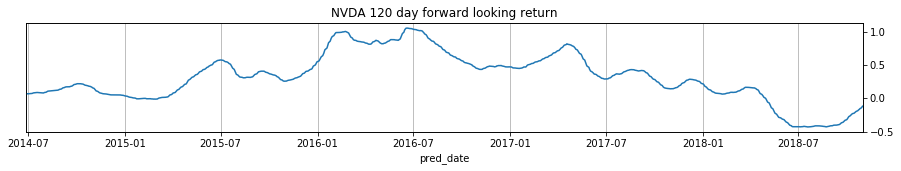

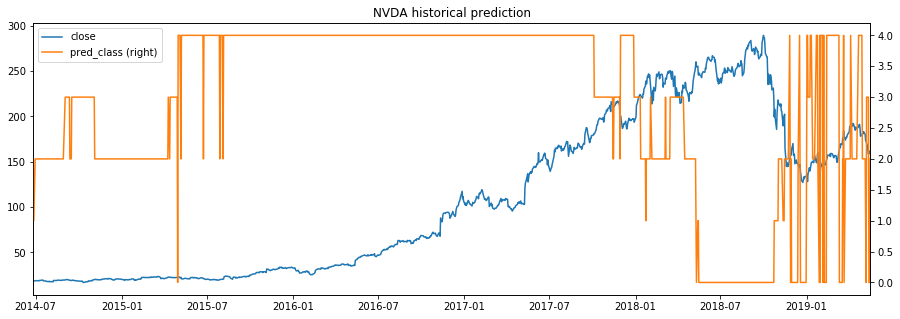

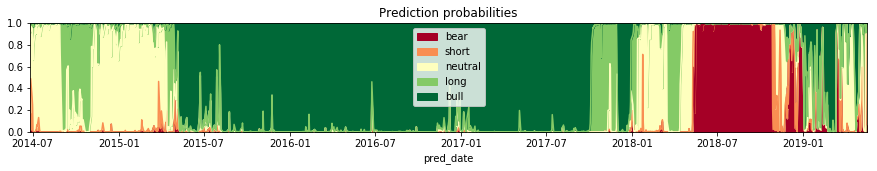

In [20]:
def plot_symbol_hist_pred(pred_symbol, clean_co_px, context, pred_df):
    
    # pred_symbol = random.choice(joined_df.symbol.unique())
    pred_symbol = pred_symbol if pred_symbol is not None else random.choice(joined_df.symbol.unique())
    px_df = clean_co_px[pred_symbol]
    px_df.name = 'close'
    look_ahead = context['look_ahead']
    pct_chg_df = px_fwd_ret(px_df, look_ahead, int(look_ahead/4))
    pct_chg_df.name = 'pct_chg'

    co_pred = pred_df.loc[pred_df.symbol.isin([pred_symbol]), ['pred_class'] + fwd_ret_labels]
    hist_pred = pd.concat([px_df.loc[pred_df.index.unique()], co_pred['pred_class']], axis=1, sort=False)

    # forward looking returns
    pct_chg_df.loc[pred_df.index.unique()].dropna().plot(
        title=f'{pred_symbol} {int(np.mean(context["look_ahead"]))} day forward looking return', 
        figsize=(15, 2), grid=True, secondary_y='pct_chg')

    # historical predictions
    hist_pred.dropna().plot(
        title=f'{pred_symbol} historical prediction', 
        figsize=(15, 5), secondary_y='pred_class')

    # probability distribution
    co_pred[fwd_ret_labels].plot.area(
        title='Prediction probabilities', 
        figsize=(15, 2), ylim=(0, 1), cmap='RdYlGn', rot=0)
    
plot_symbol_hist_pred('NVDA', clean_co_px, context, pred_df)

#### AI driven portfolio construction, single period

In [21]:
loss_protection = False
long = True
max_loss = 0.1
holding_period = 60
as_of_date = -holding_period; study_period = -30;
min_confidence = 0.8
max_class_rows = 50
nbr_positions = 30
pred_classes = [3, 4] if long else [0, 1]
period_range = list(range(-holding_period, -pred_df.index.unique().shape[0], -holding_period))

In [22]:
def get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows):
    """ return top recommendatins by label as of a given date """
    label_mask = (pred_df.pred_label.isin(['bear', 'short', 'long', 'bull'])) \
        & (pred_df.confidence > min_confidence)

    top_pred = pred_df.loc[(pred_df.index == pred_df.index.unique()[as_of_date]) & label_mask]\
        .sort_values(by=['pred_label', 'confidence'], ascending=False)\
        .groupby(by='pred_label').head(max_class_rows)
    
    return top_pred
    
top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)

In [23]:
def get_study_date_range(pred_df, as_of_date, study_period):
    """ 
    return date range for a study period, as of = prediction, 
    study period = number of days to observe stability of predictions    
    """
    return pred_df.index.unique()[study_period + as_of_date:as_of_date]

study_dates = get_study_date_range(pred_df, as_of_date, study_period)
study_dates

Index([2019-01-11, 2019-01-14, 2019-01-15, 2019-01-16, 2019-01-17, 2019-01-18,
       2019-01-21, 2019-01-22, 2019-01-23, 2019-01-24, 2019-01-25, 2019-01-28,
       2019-01-29, 2019-01-30, 2019-01-31, 2019-02-01, 2019-02-04, 2019-02-05,
       2019-02-06, 2019-02-07, 2019-02-08, 2019-02-11, 2019-02-12, 2019-02-13,
       2019-02-14, 2019-02-15, 2019-02-18, 2019-02-19, 2019-02-20, 2019-02-21],
      dtype='object', name='pred_date')

In [24]:
# historical recomendations for top predictions
def get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, treshold=0.6):
    """ return most frequent predictions of a given class for a study period """
    
    # print(f'Most frequent predictions as of {study_dates[-1]} for classes {pred_classes}')
    last_xdays_pred = pred_df.loc[study_dates]
    
    last_xdays_pred = last_xdays_pred.loc[
        last_xdays_pred.symbol.isin(list(top_pred.symbol)), 
        ['symbol', 'pred_class', 'confidence']
    ].reset_index()

    most_freq_df = last_xdays_pred.groupby(
        by=['symbol', 'pred_class'])\
        .agg(['count', 'mean']).reset_index()
    
    return most_freq_df.loc[
        most_freq_df['pred_class'].isin(pred_classes)\
        & (most_freq_df[('confidence','count')] > int(len(study_dates) * treshold))]\
        .sort_values(by=('confidence', 'count'), ascending=False)
        
most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
top_pos = most_freq_df.head(nbr_positions)
symbols = list(top_pos.symbol)
print(f'{len(symbols)} Symbols: {symbols}')
top_pos

8 Symbols: ['CHE', 'EW', 'NI', 'TMK', 'KMPR', 'NKTR', 'SIVB', 'DFS']


symbol pred_class confidence     
                           count mean
37     CHE          3         27 0.95
55      EW          4         25 0.81
135     NI          3         25 0.86
217    TMK          3         24 0.92
91    KMPR          3         23 0.80
137   NKTR          4         21 0.97
188   SIVB          4         21 0.88
52     DFS          3         19 0.78

In [25]:
def stop_loss(df, long, max_loss):
    truth_df = (df < 1 - max_loss) if long else (df > 1 + max_loss)
    pos = truth_df[truth_df == True]
    if len(pos): df.loc[pos.index[0]:] = df.loc[pos.index[0]]
    return df

idx = clean_co_px.index.get_loc(study_dates[-1])
prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
port_index = get_ind_index(prices, tail=holding_period, name='PORT')

if loss_protection:
    port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
    port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return

print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
print(f'Portfolio shape: {port_index.shape}')

Showing returns from Index([2019-02-21, 2019-05-16], dtype='object')
Portfolio shape: (60, 9)


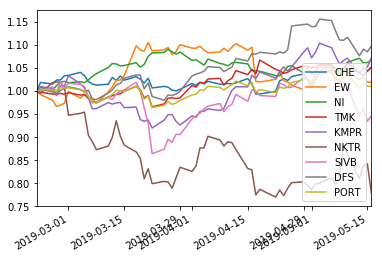

In [26]:
port_index.plot()

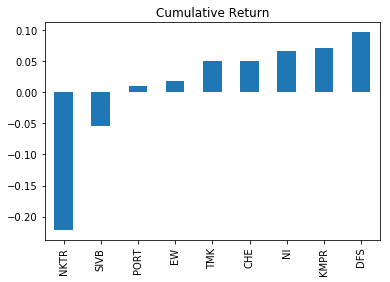

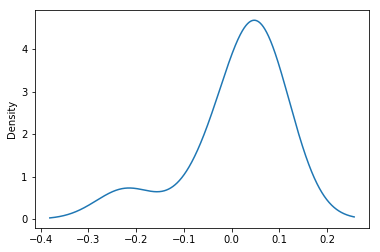

In [27]:
(port_index.iloc[-1] - 1).sort_values().plot.bar(title='Cumulative Return'); plt.show()
(port_index.iloc[-1] - 1).plot.kde();

In [28]:
# cumulative returns for a given portfolio
port_index.iloc[-1].describe()

count   9.00
mean    1.01
std     0.10
min     0.78
25%     1.01
50%     1.05
75%     1.07
max     1.10
Name: 2019-05-16 00:00:00, dtype: float64

In [29]:
port_index.tail()

,CHE,EW,NI,TMK,KMPR,NKTR,SIVB,DFS,PORT
2019-05-10,1.05,1.04,1.06,1.06,1.07,0.86,1.01,1.12,1.03
2019-05-13,1.04,1.02,1.07,1.04,1.04,0.81,0.94,1.08,1.01
2019-05-14,1.03,1.03,1.06,1.05,1.05,0.84,0.96,1.09,1.01
2019-05-15,1.04,1.02,1.06,1.04,1.05,0.84,0.93,1.08,1.01
2019-05-16,1.05,1.02,1.07,1.05,1.07,0.78,0.95,1.10,1.01


#### Backtesting experiment, historical periods

In [30]:
# What are the best portfolios and how do they perform?
super_list = []; symbol_list = []
for as_of_date in period_range:

    top_pred = get_top_predictions(pred_df, as_of_date, min_confidence, max_class_rows)
    study_dates = get_study_date_range(pred_df, as_of_date, study_period)
    most_freq_df = get_most_frequent_preds(pred_df, study_dates, top_pred, pred_classes, 0.6)
    top_pos = most_freq_df.head(nbr_positions)
    symbols = list(top_pos.symbol)
    
    if len(symbols) > 3:
        idx = clean_co_px.index.get_loc(study_dates[-1])
        prices = clean_co_px.iloc[idx:idx+holding_period][symbols]
        port_index = get_ind_index(prices, tail=holding_period, name='PORT')
        
        if loss_protection:
            port_index = port_index.iloc[:,:-1].apply(stop_loss, args=(long, max_loss)) # stop loss treatment
            port_index = get_ind_index(port_index, tail=holding_period, name='PORT') # recalc portfolio return
        # print(f'Showing returns from {clean_co_px.iloc[idx:idx+holding_period].index[[0,-1]]}')
        
        exp = port_index.iloc[-1].describe()
        exp['offset_start'] = as_of_date
        exp['as_of_date'] = str(study_dates[-1])
        exp['study_period'] = study_period
        exp['end_date'] = str(port_index.index[-1])
        symbol_list.append(symbols)
        super_list.append(exp)
        
hist_ports = pd.concat(super_list, axis=1).T

Summary for 20 experiment LONG periods
196 unique symbols


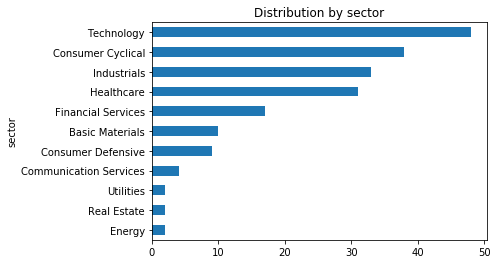

sector              industry                           
Technology          Software - Application                 11
                    Semiconductors                          9
Healthcare          Medical Instruments & Supplies          8
Industrials         Business Services                       7
Technology          Internet Content & Information          7
Healthcare          Diagnostics & Research                  7
Industrials         Diversified Industrials                 6
Consumer Cyclical   Specialty Retail                        6
Basic Materials     Specialty Chemicals                     6
Healthcare          Health Care Plans                       6
                    Biotechnology                           5
Financial Services  Credit Services                         5
Industrials         Airlines                                5
Technology          Scientific & Technical Instruments      4
Consumer Cyclical   Footwear & Accessories                  4
Technology    

In [31]:
# Descriptive stats
print(f'Summary for {len(period_range)} experiment {"LONG" if long else "SHORT"} periods')
unique_symbols = set(np.concatenate(symbol_list))
print(f'{len(unique_symbols)} unique symbols')

by_sect = profile.loc[unique_symbols].groupby(by=['sector']).count().iloc[:,0]\
      .sort_values()
by_sect.plot.barh(title='Distribution by sector');
plt.show()

by_ind = profile.loc[unique_symbols].groupby(by=['sector', 'industry']).count().iloc[:,0]\
      .sort_values(ascending=False)
by_ind.head(20)

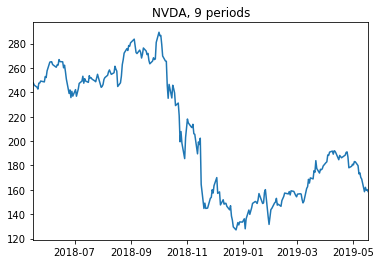

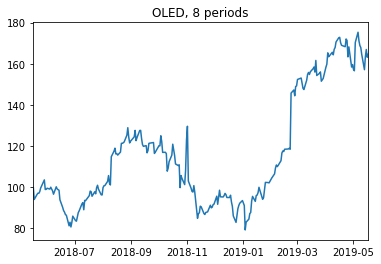

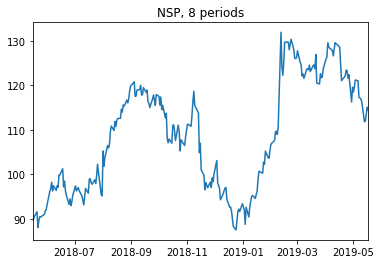

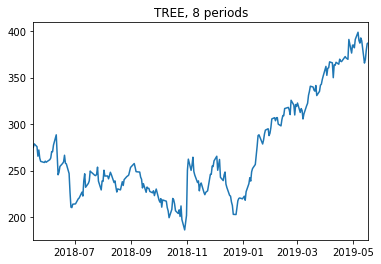

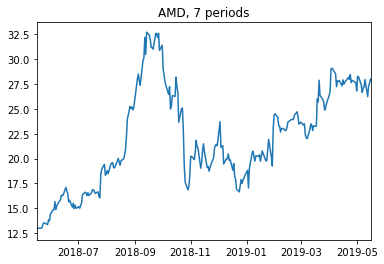

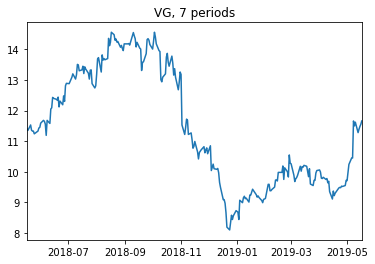

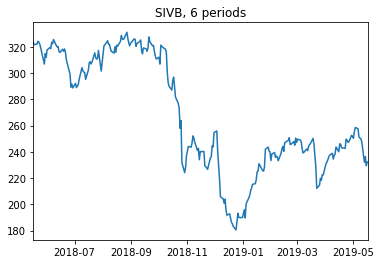

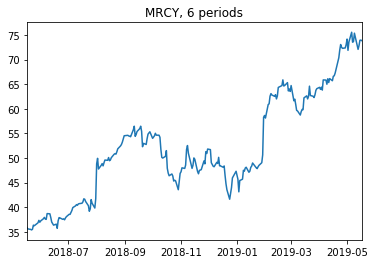

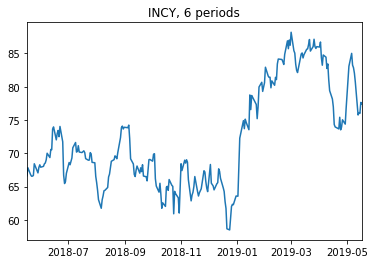

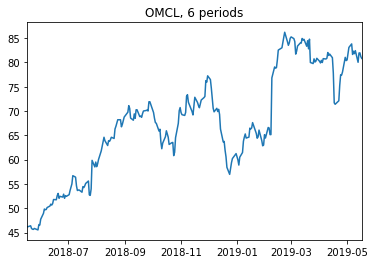

In [32]:
# Most common recommendations
from collections import Counter
pos_freq = Counter(np.concatenate(symbol_list)).most_common()
for t in pos_freq[:10]: clean_co_px[t[0]].tail(252).plot(title=f'{t[0]}, {t[1]} periods'); plt.show()

In [33]:
mkt_cap_cuts = [0, 0.3, 2, 10, 300, 5000]
mkt_cap_labels = ['micro', 'small', 'mid', 'large', 'mega']

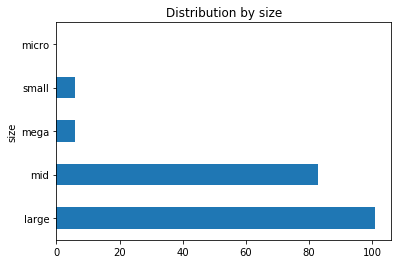

In [34]:
size_df = quotes.loc[unique_symbols, ['marketCap']] / 10**9
size_df['size'] = discret_rets(size_df.marketCap, mkt_cap_cuts, mkt_cap_labels)
size_df.groupby(by=['size']).count().iloc[:,0].sort_values(ascending=False).plot.barh(title='Distribution by size');

Long CAGR: 0.99


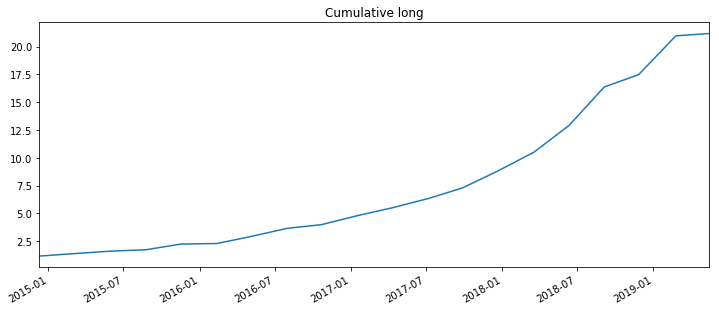

In [35]:
hist_ports.sort_index(inplace=True)
years = (hist_ports.index[-1] - hist_ports.index[0]).days / 365
if long:
    mean_ret = pd.DataFrame()
    mean_ret['long'] = hist_ports['mean'].sort_index()
    mean_ret['long'].cumprod().plot(title='Cumulative long', figsize=(12,5));
    print(f'Long CAGR: {round((mean_ret["long"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
else:
    mean_ret['short'] = hist_ports['mean'].sort_index()
    mean_ret['short'].cumprod().plot(title='Cumulative short', figsize=(12,5));
    print(f'Short CAGR: {round((mean_ret["short"].cumprod().iloc[-1] ** (1/years) - 1), 2)}')
if 'long' in mean_ret.columns and 'short' in mean_ret.columns:
    mean_ret['ls'] = (mean_ret['long'] - mean_ret['short'] + 1)
    mean_ret.cumprod().plot(title='Long/Short', figsize=(12,5))          
    print(f'L/S CAGR: {(mean_ret["ls"].cumprod().iloc[-1] ** (1/years) - 1)}')

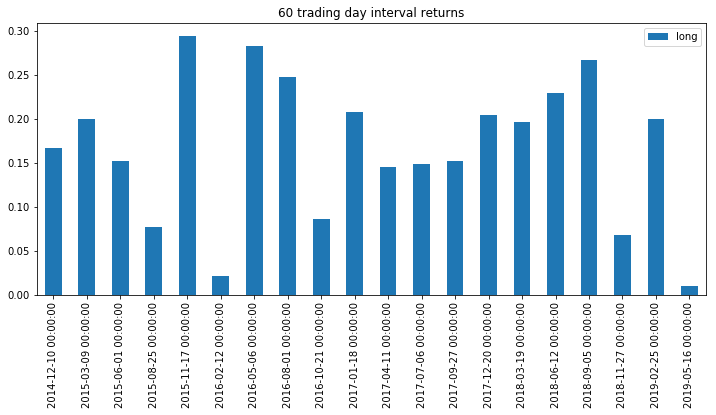

In [36]:
(mean_ret-1).plot(
    title=f'{holding_period} trading day interval returns', 
    kind='bar', figsize=(12,5))

In [37]:
def calc_monthly_ret(l_w, mean_ret):
    monthly_ret = (
        (mean_ret['long'] - 1).mul(l_w) - 
        (mean_ret['short'] - 1).mul(1 - l_w) + 1)
    mix_df = monthly_ret.infer_objects().describe()
    mix_df['l'] = l_w
    mix_df['s'] = 1 - l_w
    return monthly_ret, mix_df

In [38]:
# optimal L/S mix
super_list = []
series = np.arange(0.4, 1.2, 0.05)
if 'short' in mean_ret.columns:
    for l_w in series:
        monthly_ret, mix_df = calc_monthly_ret(l_w, mean_ret)
        super_list.append(mix_df)
        monthly_ret.cumprod().plot()
    scenarios = pd.concat(super_list, axis=1).T
    opt_wgt = series[np.argmax(((scenarios['mean'] - 1) / scenarios['std']))]
    
    # expected long-term return at optimal L/S mix
    monthly_ret, _ = calc_monthly_ret(opt_wgt, mean_ret)
    print(f'Expected return = {round(monthly_ret.cumprod().iloc[-1] ** (1/years) - 1, 2)*100}% at {round(opt_wgt, 2)} long {round(1 - opt_wgt, 2)} short')
    monthly_ret.cumprod().plot();

In [39]:
hist_ports.infer_objects()['mean'].describe()

count   20.00
mean     1.17
std      0.08
min      1.01
25%      1.13
50%      1.18
75%      1.21
max      1.29
Name: mean, dtype: float64

In [40]:
hist_ports.infer_objects().describe()

,count,mean,std,min,25%,50%,75%,max,offset_start,study_period
count,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00,20.00
mean,26.50,1.17,0.14,0.96,1.08,1.15,1.22,1.53,-630.00,-30.00
std,8.34,0.08,0.03,0.09,0.06,0.07,0.10,0.22,354.96,0.00
min,8.00,1.01,0.08,0.78,0.95,1.01,1.07,1.10,"-1,200.00",-30.00
25%,28.50,1.13,0.11,0.93,1.04,1.12,1.17,1.38,-915.00,-30.00
50%,31.00,1.18,0.13,0.98,1.08,1.15,1.22,1.51,-630.00,-30.00
75%,31.00,1.21,0.15,1.01,1.13,1.19,1.26,1.67,-345.00,-30.00
max,31.00,1.29,0.20,1.09,1.17,1.32,1.40,1.98,-60.00,-30.00


In [41]:
hist_ports.sort_values(by='offset_start')

,count,mean,std,min,25%,50%,75%,max,offset_start,as_of_date,study_period,end_date
2014-12-10,31.00,1.17,0.09,1.02,1.09,1.17,1.22,1.37,"-1,200.00",2014-09-17,-30,2014-12-10 00:00:00
2015-03-09,31.00,1.20,0.13,0.98,1.13,1.16,1.24,1.61,"-1,140.00",2014-12-10,-30,2015-03-09 00:00:00
2015-06-01,31.00,1.15,0.16,0.81,1.07,1.13,1.22,1.60,"-1,080.00",2015-03-06,-30,2015-06-01 00:00:00
2015-08-25,31.00,1.08,0.13,0.97,1.01,1.04,1.10,1.71,"-1,020.00",2015-06-02,-30,2015-08-25 00:00:00
2015-11-17,8.00,1.29,0.14,1.09,1.17,1.32,1.40,1.50,-960.00,2015-08-25,-30,2015-11-17 00:00:00
2016-02-12,31.00,1.02,0.13,0.79,0.95,1.01,1.07,1.37,-900.00,2015-11-17,-30,2016-02-12 00:00:00
2016-05-06,31.00,1.28,0.20,0.99,1.15,1.27,1.37,1.98,-840.00,2016-02-11,-30,2016-05-06 00:00:00
2016-08-01,31.00,1.25,0.17,1.01,1.15,1.20,1.30,1.80,-780.00,2016-05-06,-30,2016-08-01 00:00:00
2016-10-21,31.00,1.09,0.08,0.94,1.02,1.09,1.13,1.25,-720.00,2016-07-29,-30,2016-10-21 00:00:00
2017-01-18,31.00,1.21,0.14,0.98,1.10,1.19,1.28,1.52,-660.00,2016-10-21,-30,2017-01-18 00:00:00
